# French Motor Third-Party Liability Claims

Adapted from https://github.com/lorentzenchr/Tutorial_freMTPL2

case study paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764

R code: https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/1%20-%20French%20Motor%20Third-Party%20Liability%20Claims

## 1. Import Libraries and Helper Functions

In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sparse

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import GeneralizedLinearRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

In [93]:
def calc_obs_pred(df, feature, observed, predicted, weight):
    """Calculate a DataFrame with observed and predicted - aggregated per feature level.
    
    This makes most sense for categorical features.

    Returns
    -------
    df_ : DataFrame with columns ['observed', 'predicted']
    """
    df_ = df.loc[:, [feature, weight]].copy()
    df_['observed'] = df[observed] * df[weight]
    df_['predicted'] = df[predicted] * df[weight]    
    df_ = (df_.groupby([feature])[weight, 'observed', 'predicted']
          .sum()
          .assign(observed = lambda x: x['observed']/x[weight])
          .assign(predicted = lambda x: x['predicted']/x[weight])
    )
    return df_

def plot_obs_pred(df, feature, observed, predicted, weight,
                  y_label=None, title=None, kind_weight=None, ax=None):
    """Plot observed and predicted - aggregated per feature level.
    
    Parameters
    ----------
    df : DataFrame with at least one column named feature
    observed : str
        a column name of the observed target
    predicted : str
        a column name of the predicted target
    weight : str
        column name with the values of weights/exposure
    """
    df_plot = calc_obs_pred(df, feature, observed, predicted, weight)

    ax = df_plot.loc[:, ['observed', 'predicted']].plot(style='.', ax=ax)
    y_max = df_plot.loc[:, ['observed', 'predicted']].values.max()*0.8
    ax.fill_between(df_plot.index, 0,
                    y_max*df_plot[weight] / df_plot[weight].values.max(),
                    color='g', alpha=0.1)
    ax.set(ylabel=y_label if y_label is not None else None,
           title=title if title is not None else 'Train: Observed vs Predicted')

## 2. Load and Prepare Datasets from Openml.org
'freMTPL2freq' (id=41214) is a dataset with policy id (IDpol), several features and number of claims (ClaimNb).
<br>
'freMTPL2sev' (id=41215) has only policy id (IDpol) and total claim amount (ClaimAmount).
<br> http://dutangc.free.fr/pub/RRepos/web/CASdatasets-index.html

In [3]:
def load_mtpl2():
    """Fetcher for the MTPL2 dataset
    
    Corresponding to French Motor Third-Party Liability Claims
    """

    # Note: this should use the OpenML DataFrame fetcher in the future
    df_freq = pd.read_csv(
        "https://www.openml.org/data/get_csv/20649148/freMTPL2freq.csv",
        dtype={'IDpol': np.int},
        index_col=0
    )

    df_sev = pd.read_csv(
        "https://www.openml.org/data/get_csv/20649149/freMTPL2sev.arff",
        index_col=0
    )
    
    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby(level=0).sum()

    df = df_freq.join(df_sev, how='left')
    df['ClaimAmount'].fillna(0, inplace=True)
    
    # unquote string fields
    for column_name in df.columns[df.dtypes.values == np.object]:
        df[column_name] = df[column_name].str.strip("'") 
    return df

In [5]:
df = load_mtpl2()

In [6]:
# Note: claims with zero amount must be ignored in severity model 
# as support is (0, inf) not [0, inf).
df.loc[(df.ClaimAmount == 0) & (df.ClaimNb >= 1), 'ClaimNb'] = 0

In [7]:
df[df.ClaimAmount>0].head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
139,1,0.75,F,7,1,61,50,B12,Regular,27000,R11,303.00
190,1,0.14,B,12,5,50,60,B12,Diesel,56,R25,1981.84
414,1,0.14,E,4,0,36,85,B12,Regular,4792,R11,1456.55
424,2,0.62,F,10,0,51,100,B12,Regular,27000,R11,10834.00
463,1,0.31,A,5,0,45,50,B12,Regular,12,R73,3986.67


In [8]:
df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05
mean,0.039004,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01
std,0.207176,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06


In [9]:
# correct for unreasonable observations (that might be data error)
df['ClaimNb'].clip(upper=4, inplace=True)
df['Exposure'].clip(upper=1, inplace=True)

In [10]:
df['BonusMalus'].describe()

count    678013.000000
mean         59.761502
std          15.636658
min          50.000000
25%          50.000000
50%          50.000000
75%          64.000000
max         230.000000
Name: BonusMalus, dtype: float64

## 2. Feature Transformation Pipeline for GLMs

In [11]:
%%time

column_trans = ColumnTransformer(
    [
     ('Veh_Driv_Age', KBinsDiscretizer(n_bins=10), ['VehAge', 'DrivAge']),
     ('Veh_Brand_Gas_Region', OneHotEncoder(), ['VehBrand', 'VehPower', 'VehGas', 'Region', 'Area']),
     ("BonusMalus",  "passthrough", ["BonusMalus"]),
     ('Density_log',
          make_pipeline(FunctionTransformer(np.log, validate=False),
                        StandardScaler()),
      ['Density']),
    ],
    remainder = 'drop'
)
X = column_trans.fit_transform(df)

CPU times: user 2.94 s, sys: 80 ms, total: 3.02 s
Wall time: 785 ms


## 3. Frequency model -- Poisson distribution
From now on, we use claim number with positive claim amount `ClaimNb`.

In [29]:
%%time

df['Frequency'] = df.ClaimNb/df.Exposure
df["AvgClaimAmount"] = df.ClaimAmount / np.fmax(df.ClaimNb, 1)


df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=2)


glm_freq = GeneralizedLinearRegressor(family='poisson', alpha=0)
glm_freq.fit(X_train, df_train.Frequency, sample_weight=df_train.Exposure)

CPU times: user 7.05 s, sys: 441 ms, total: 7.49 s
Wall time: 2.22 s


In [76]:
from sklearn.metrics import mean_absolute_error, r2_score

def score_estimator(estimator, target, weight, X_train, X_test, df_train, df_test):
    res = []
   
    for subset_label, X, y, weights in [
                ('train', X_train, df_train[target], df_train[weight]),
                ('test', X_test, df_test[target], df_test[weight])]:
        for score_label, metric in [
           ('D² explained', None),
           ('average deviance',
               lambda y, y_pred, weights: estimator._family_instance.deviance(y, y_pred, weights) / len(y)),
           ('MAE', mean_absolute_error),
           ('R²', r2_score)
    ]:
            y_pred = estimator.predict(X)
            if score_label == 'D² explained':
                score = estimator.score(X, y, weights)
            else:
                
                score = metric(y, y_pred, weights)
            
            res.append({
                "subset": subset_label,
                "metric": score_label,
                "score": score
            })
    
    res = (pd.DataFrame(res).set_index(['metric', 'subset'])
                        .score
                        .unstack(-1)
                        .round(3))
    return res

score_estimator(glm_freq, "Frequency", "Exposure", X_train, X_test, df_train, df_test)

subset,test,train
metric,,
D² explained,0.041,0.045
MAE,0.137,0.139
R²,0.003,0.008
average deviance,0.238,0.243


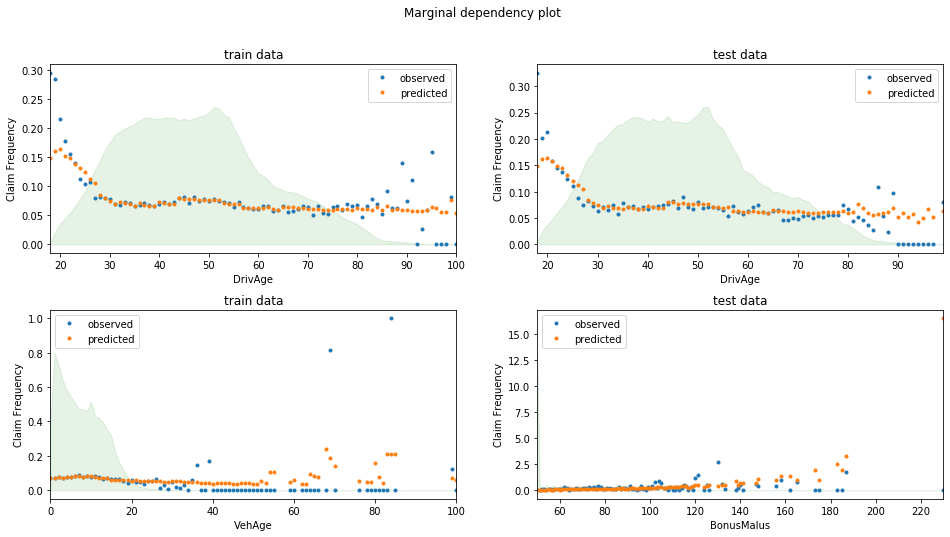

In [95]:
df_plot_train, df_plot_test = df_train.copy(), df_test.copy()

df_plot_train['Freq_Predicted'] = glm_freq.predict(X_train)
df_plot_test['Freq_Predicted'] = glm_freq.predict(X_test)


fig, ax = plt.subplots(2, 2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)


# plot DivAge
plot_obs_pred(df_plot_train, 'DrivAge', 'Frequency', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='train data',
              ax=ax[0, 0])

plot_obs_pred(df_plot_test, 'DrivAge', 'Frequency', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='test data',
              ax=ax[0, 1])

# plot VehAge
plot_obs_pred(df_plot_train, 'VehAge', 'Frequency', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='train data', ax=ax[1, 0])

plot_obs_pred(df_plot_test, 'BonusMalus', 'Frequency', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='test data', ax=ax[1, 1])

fig.suptitle("Marginal dependency plot");


## 4. Severity GLM -  Gamma Distribution
We fit a GLM model for the severity with the same features as the freq model.

Note:
- We filter out ClaimAmount == 0 as the Gamma distribution as support on $(0, \infty)$ not $[0, \infty)$
- We use ClaimNb as sample weights.
- We use the same split in train and test data such that we can predict the final claim amount on the test set.

In [15]:
mask_train = df_train['ClaimAmount'] > 0
mask_test = df_test['ClaimAmount'] > 0

glm_sev = GeneralizedLinearRegressor(family='gamma', alpha=1)

glm_sev.fit(X_train[mask_train.values], df_train.loc[mask_train, 'AvgClaimAmount'],
            sample_weight=df_train.loc[mask_train, 'ClaimNb'])

GeneralizedLinearRegressor(P1='identity', P2='identity', alpha=1,
                           check_input=True, copy_X=True, diag_fisher=False,
                           family='gamma', fit_dispersion=None,
                           fit_intercept=True, l1_ratio=0, link='auto',
                           max_iter=100, random_state=None, selection='cyclic',
                           solver='auto', start_params='guess', tol=0.0001,
                           verbose=0, warm_start=False)

In [56]:
score_estimator(glm_sev, 'AvgClaimAmount', 'ClaimNb',
                X_train[mask_train.values], X_test[mask_test.values],
                df_train[mask_train], df_test[mask_test])

subset,test,train
metric,,
D² explained,0.015,0.058
MAE,2100.691,2315.521
R²,0.000,0.001
average deviance,1.637,1.743


In [57]:
df_train.AvgClaimAmount[df_train.AvgClaimAmount].mean()

2.2785482990722215

In [58]:
df_train.AvgClaimAmount[df_train.AvgClaimAmount > 0].mean()

2272.6940375132554

In [59]:
glm_sev.predict(X_train[~mask_train.values]).mean()

2122.179025984535

In [71]:
glm_freq.predict(X_train[~mask_train.values], sample_weight=df_train.Exposure[~mask_train]).mean()

0.038056571805792694

In [69]:
df_train.loc[~mask_train, 'Frequency'].mean()

0.0

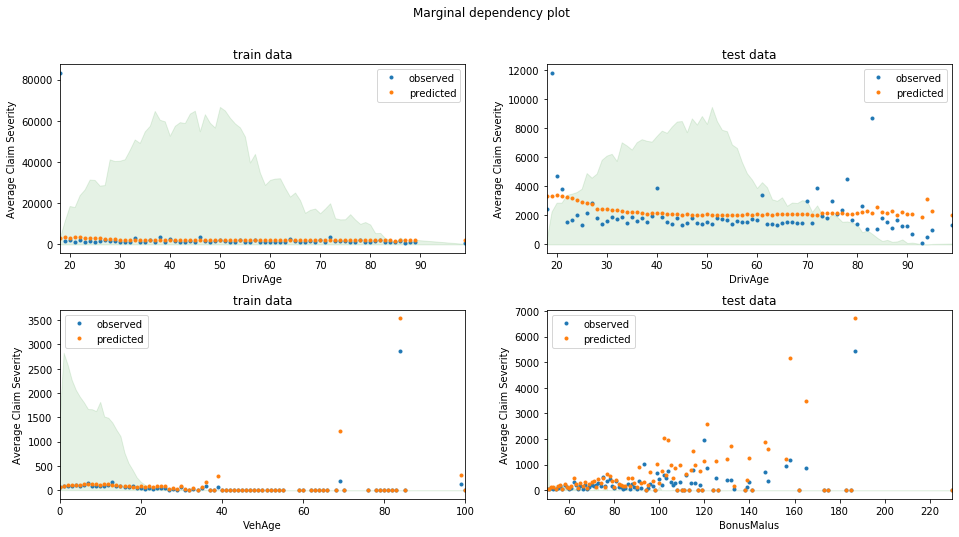

In [28]:
df_plot_train = df_train.copy()

df_plot_train.loc[mask_train, 'AvgClaimAmount_pred'] = glm_sev.predict(X_train[mask_train.values])
df_plot_test.loc[mask_test,'AvgClaimAmount_pred'] = glm_sev.predict(X_test[mask_test.values])


fig, ax = plt.subplots(2, 2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

fig.suptitle("Marginal dependency plot")

# plot DivAge
plot_obs_pred(df_plot_test.loc[mask_test],
              'DrivAge', 'AvgClaimAmount', 'AvgClaimAmount_pred', 'Exposure',
              y_label='Average Claim Severity', title='train data', ax=ax[0, 0])

plot_obs_pred(df_plot_train.loc[mask_train],
              'DrivAge', 'AvgClaimAmount', 'AvgClaimAmount_pred', 'Exposure',
              y_label='Average Claim Severity', title='test data', ax=ax[0, 1])

# plot VehAge
plot_obs_pred(df_plot_train, 'VehAge', 'AvgClaimAmount', 'AvgClaimAmount_pred', 'Exposure',
              y_label='Average Claim Severity', title='train data', ax=ax[1, 0])

plot_obs_pred(df_plot_test, 'BonusMalus', 'AvgClaimAmount', 'AvgClaimAmount_pred', 'Exposure',
              y_label='Average Claim Severity', title='test data', ax=ax[1, 1])

## 5. Total loss - Compound Poisson

The total loss (i.e. `ClaimAmount`) can be modeled as either the product of the frequency model (`glm_freq`) by the severity model (`glm_sev`), or as a compound Poisson distribution 

In [111]:
from sklearn.linear_model._glm import TweedieDistribution

In [113]:
from sklearn.model_selection import GridSearchCV

# this takes a while
params = {'family': [TweedieDistribution(power=power)
                     for power in np.linspace(1, 2, 20)]}

glm_cv = GridSearchCV(GeneralizedLinearRegressor(), cv=5, param_grid=params, n_jobs=4)
glm_cv.fit(X_train, df_train['ClaimAmount'],
           sample_weight=df_train['Exposure'])

GridSearchCV(cv=5, error_score=nan,
             estimator=GeneralizedLinearRegressor(P1='identity', P2='identity',
                                                  alpha=1.0, check_input=True,
                                                  copy_X=True,
                                                  diag_fisher=False,
                                                  family='normal',
                                                  fit_dispersion=None,
                                                  fit_intercept=True,
                                                  l1_ratio=0, link='auto',
                                                  max_iter=100,
                                                  random_state=None,
                                                  selection='cyclic',
                                                  solver='auto',
                                                  start_params='guess',
                                                  

In [115]:
glm_cv.best_estimator_.family.power

1.368421052631579

In [116]:
family = TweedieDistribution(power=1.37)

glm_total = GeneralizedLinearRegressor(family=family)

glm_total.fit(X_train, df_train['ClaimAmount'],
            sample_weight=df_train['Exposure'])

GeneralizedLinearRegressor(P1='identity', P2='identity', alpha=1.0,
                           check_input=True, copy_X=True, diag_fisher=False,
                           family=<sklearn.linear_model._glm.TweedieDistribution object at 0x7fb68f6a6b38>,
                           fit_dispersion=None, fit_intercept=True, l1_ratio=0,
                           link='auto', max_iter=100, random_state=None,
                           selection='cyclic', solver='auto',
                           start_params='guess', tol=0.0001, verbose=0,
                           warm_start=False)

In [117]:
score_estimator(glm_total, 'ClaimAmount', 'Exposure',
                X_train, X_test, df_train, df_test)

subset,test,train
metric,,
D² explained,0.044,0.073
MAE,175.596,185.163
R²,-0.000,0.000
average deviance,54.429,56.885


In [119]:

for label, X, df in [('train', X_train, df_train),
                     ('test', X_test, df_test)]:
    print("Total claim amount on {} set, observed = {:.0f}, pred (freq*sev) = {:.0f}, pred (tweedie) = {:.0f}".
         format(
             label,
             df['ClaimAmount'].values.sum(),
             np.sum(df['Exposure'].values * glm_freq.predict(X) * glm_sev.predict(X)),
             np.sum(glm_total.predict(X))
     ))

Total claim amount on train set, observed = 46355171, pred (freq*sev) = 45235715, pred (tweedie) = 53066135
Total claim amount on test set, observed = 13554045, pred (freq*sev) = 15159626, pred (tweedie) = 17738888
